In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import re

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

### 전처리

In [2]:
buoy = pd.read_csv('buoy.csv',encoding='utf-8')

In [3]:
buoy.sample(10)

,Unnamed: 0,loc,year,month,day,유의파고 평균,최대파고 최고,최대파고 시간,파주기 평균,파주기 최고,평균풍속,평균 현지기압,평균습도,평균기온,평균수온
7380,7380,22185,2018,4,월,0.7,1.9,NaN,5,6.6,NaN,1016.1,85,8,7
8767,8767,22188,2017,2,11,1.9,3.7,22,5,5.8,11.6,1022.7,60,1.7,10
6488,6488,22184,2017,7,월,0.9,2.1,NaN,6,7.3,5.3,1007.1,90,26.7,26.5
348,348,21229,2017,10,6,1.2,2.8,18,5.2,5.8,6,1020,80,19.6,21.3
5071,5071,22108,2017,2,22,1.1,4,24,4.7,6.4,8.6,1015.7,80,3.9,5.1
3267,3267,22105,2017,4,7,0.8,2,2,5.8,8,2.9,1014.2],81,14,14
6646,6646,22184,2018,1,19,0.8,1.8,8,3.9,4.3,7,1022.5,51,5.4,14.1
5015,5015,22108,2017,1,3,x,x,x,x,x,x,x,x,x,x
9091,9091,22188,2017,12,26,1.4,3.7,24,4.9,9.1,10.6,1023.6,57,5.3,12
4881,4881,22107,2018,4,7,3.6,7.5,7,8.4,9.1,11.4,1020.4,58,8.6,15.3


In [4]:
buoy.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
buoy.columns = ['stn', 'year', 'month', 'day', '유의파고 평균', '최대파고 최고', '최대파고 시간',
       '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도', '평균기온', '평균수온']# 칼럼명 loc이 메소드이름과 겹치기에 stn으로 바꾸었다

In [6]:
buoy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 14 columns):
stn        10506 non-null int64
year       10506 non-null int64
month      10506 non-null int64
day        10506 non-null object
유의파고 평균    10384 non-null object
최대파고 최고    10385 non-null object
최대파고 시간    9193 non-null object
파주기 평균     10374 non-null object
파주기 최고     10374 non-null object
평균풍속       10328 non-null object
평균 현지기압    10354 non-null object
평균습도       10275 non-null object
평균기온       10344 non-null object
평균수온       10370 non-null object
dtypes: int64(3), object(11)
memory usage: 1.1+ MB


In [7]:
buoy.stn = buoy.stn.astype('category') 

In [8]:
buoy.describe(include='category') #17개의 관측지점

,stn
count,10506
unique,17
top,22190
freq,618


In [9]:
#re를 이용해 불필요한 문자 정보를 제거한다
buoy.replace(to_replace = '[>]',value=r'',regex=True,inplace=True)
buoy.replace(to_replace = '[)]',value=r'',regex=True,inplace=True)
buoy.replace(to_replace = '[]]',value=r'',regex=True,inplace=True)
buoy.replace(to_replace = '[x]',value=np.nan,regex=True,inplace=True)
buoy.replace(to_replace = '[null]',value=np.nan,regex=True,inplace=True)
buoy.replace(to_replace = '',value=np.nan,regex=True,inplace=True)

In [10]:
buoy.iloc[:,4:] = buoy.iloc[:,4:].astype('float64')

데이터가 월별보고 이므로 상순,중순,하순,월 별 평균값이 존재한다

필요없는 데이터이므로 제거한다

In [11]:
buoy[buoy.day.str.contains(r'\D+')].head()

,stn,year,month,day,유의파고 평균,최대파고 최고,최대파고 시간,파주기 평균,파주기 최고,평균풍속,평균 현지기압,평균습도,평균기온,평균수온
10,21229,2016,11,상순,2.1,4.8,NaN,7.3,8.6,8.1,1021.4,63.0,12.3,19.2
21,21229,2016,11,중순,1.4,3.2,NaN,6.2,8.7,6.0,1018.8,66.0,15.3,18.1
32,21229,2016,11,하순,1.9,4.5,NaN,6.8,8.3,7.4,1022.4,64.0,9.8,17.8
33,21229,2016,11,월,1.8,4.2,NaN,6.8,8.5,7.2,1020.9,64.0,12.5,18.4
44,21229,2016,12,상순,1.9,4.6,NaN,6.7,8.1,7.4,1019.0,57.0,10.8,16.3


In [12]:
buoy[buoy.day.str.contains(r'\D+')].axes[0]

Int64Index([   10,    21,    32,    33,    44,    55,    67,    68,    79,
               90,
            ...
            10435, 10436, 10447, 10458, 10469, 10470, 10481, 10492, 10504,
            10505],
           dtype='int64', length=1224)

In [13]:
indexToBeDropped = buoy[buoy.day.str.contains(r'\D+')].axes[0]

In [14]:
buoy.drop(index=indexToBeDropped, inplace=True)

In [15]:
buoy.reset_index(inplace=True, drop=True)

In [16]:
buoy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9282 entries, 0 to 9281
Data columns (total 14 columns):
stn        9282 non-null int64
year       9282 non-null int64
month      9282 non-null int64
day        9282 non-null object
유의파고 평균    9072 non-null float64
최대파고 최고    9111 non-null float64
최대파고 시간    9111 non-null float64
파주기 평균     9051 non-null float64
파주기 최고     9048 non-null float64
평균풍속       9036 non-null float64
평균 현지기압    9073 non-null float64
평균습도       8967 non-null float64
평균기온       9046 non-null float64
평균수온       9061 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 1015.3+ KB


In [17]:
buoy.iloc[:,4:].describe()

,유의파고 평균,최대파고 최고,최대파고 시간,파주기 평균,파주기 최고,평균풍속,평균 현지기압,평균습도,평균기온,평균수온
count,9072.000000,9111.000000,9111.000000,9051.000000,9048.000000,9036.000000,9073.000000,8967.000000,9046.000000,9061.000000
mean,1.086728,2.647075,10.913401,5.610960,7.487721,5.937096,1017.959605,71.878443,12.423701,15.120042
std,0.752915,1.724864,8.236239,1.597871,1.798572,2.761304,7.028368,14.667394,7.234280,5.624758
min,0.000000,0.300000,1.000000,2.400000,3.000000,0.200000,996.700000,0.000000,-11.000000,1.100000
25%,0.500000,1.300000,3.000000,4.400000,6.400000,3.800000,1012.400000,61.000000,6.900000,11.900000
50%,0.900000,2.200000,10.000000,5.400000,7.100000,5.600000,1018.400000,71.000000,12.200000,15.100000
75%,1.500000,3.500000,19.000000,6.600000,9.100000,7.800000,1023.300000,84.000000,17.700000,18.700000
max,5.200000,12.000000,24.000000,12.700000,16.000000,17.000000,1036.600000,100.000000,33.900000,30.700000


In [18]:
plt.rcParams['font.family'] = 'NanumSquare' #그래프 위한 폰트설정

### EDA

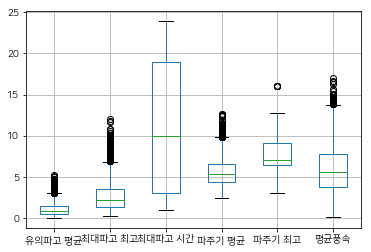

In [116]:
buoy.iloc[:,4:10].boxplot() # 간단하게 boxplot 그려보자

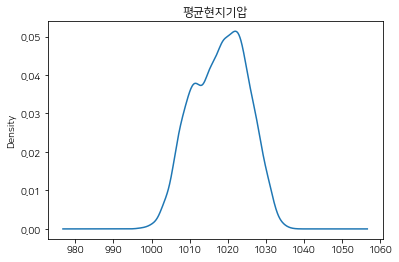

In [117]:
buoy.iloc[:,10].plot.density(title='평균현지기압')

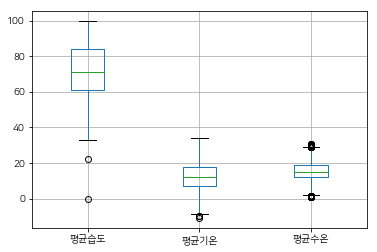

In [118]:
buoy.iloc[:,11:].boxplot()

### Clustering

In [21]:
buoy.drop(columns='최대파고 시간',inplace=True) # 불필요하다 여겨지는 최대파고 시간 정보를 제거했다

In [22]:
buoy_dropped = buoy.dropna() # 클러스터링을 위해 일단 NaN 값이 있는 row를 모두 drop 시켰다

In [27]:
len(buoy_dropped)

8703

In [76]:
X0 = buoy_dropped.iloc[:,4:] #클러스터링 위한 feature selection한다, 3가지 경우로 나누어 클러스터링 해보자
X1 = buoy_dropped.iloc[:,4:11]  
X2 = buoy_dropped.iloc[:,4:9]
Xs = [X0,X1,X2]
print(Xs[0].axes[1])
print(Xs[1].axes[1])
print(Xs[2].axes[1])

Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도',
       '평균기온', '평균수온'],
      dtype='object')
Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도'], dtype='object')
Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속'], dtype='object')


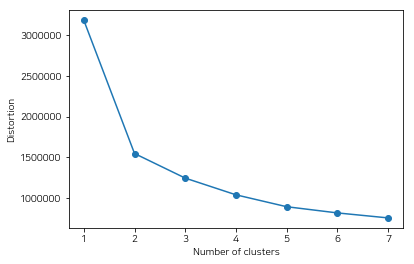

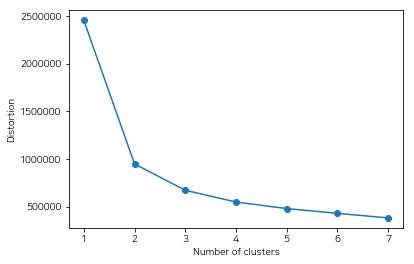

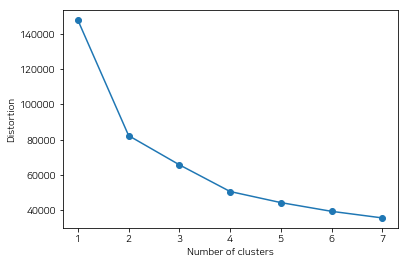

In [77]:
for i in range(len(Xs)): #wss plotting 해본다
    plt.figure(i)
    distortions = [] 
    for k in range(1,8):
        km = KMeans(n_clusters = k,
                   init='k-means++',
                   n_init = 100,
                   max_iter = 300,
                   random_state=0)
        km.fit(Xs[i])
        distortions.append(km.inertia_)
    
    plt.plot(range(1,8), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')

In [79]:
#silhouette_score도 찍어본다
for i in range(len(Xs)):
    print('For ', Xs[i].axes[1])
    for k in range(2,5):
        km = KMeans(n_clusters = k,
                   init='k-means++',
                   n_init = 100,
                   max_iter = 300,
                   random_state=0).fit(Xs[i])
        print("score for %d clusters:%.3f" % (k, silhouette_score(Xs[i], km.labels_)))

For  Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도',
       '평균기온', '평균수온'],
      dtype='object')
score for 2 clusters:0.420
score for 3 clusters:0.288
score for 4 clusters:0.292
For  Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도'], dtype='object')
score for 2 clusters:0.492
score for 3 clusters:0.369
score for 4 clusters:0.309
For  Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속'], dtype='object')
score for 2 clusters:0.398
score for 3 clusters:0.317
score for 4 clusters:0.318


#### ~~스케일링~~
>X = buoy_dropped.iloc[:,4:]
X = (X - X.mean())/X.std()
for k in range(2,6):
    km = KMeans(n_clusters = k,
               init='k-means++',
               n_init = 100,
               max_iter = 300,
               random_state=0).fit(X)
    print("score for %d clusters:%.3f" % (k, silhouette_score(X, km.labels_)))

In [120]:
#모델을 생성합니다 (k=2 or 4)
km_wave0 = KMeans(n_clusters=2)
km_wave1 = KMeans(n_clusters=2)
km_wave2 = KMeans(n_clusters=4)
# fitting 시킵니다
model_wave0 = km_wave0.fit(Xs[0])
model_wave1 = km_wave1.fit(Xs[1])
model_wave2 = km_wave2.fit(Xs[2])

model_waves = [model_wave0,model_wave1,model_wave2]

In [121]:
#각 모델별로 클러스터 값을 라벨링합니다
y_wave0 = model_wave0.predict(Xs[0]) 
y_wave1 = model_wave1.predict(Xs[1])
y_wave2 = model_wave2.predict(Xs[2])

y_waves = [y_wave0,y_wave1,y_wave2]

In [89]:
def plotSilhouette(X, y_km): #실루엣 스코어의 시각화
    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks=[]
    
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km==c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i/n_clusters)
        
        plt.barh(range(y_ax_lower,y_ax_upper), c_silhouette_vals, height=1.0,
                edgecolor='none', color=color)
        yticks.append((y_ax_lower+y_ax_upper)/2)
        y_ax_lower += len(c_silhouette_vals)
        
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle='--')
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('clusters')
    plt.xlabel('coefficient silhouette')
    plt.show()

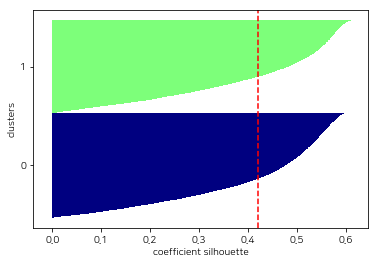

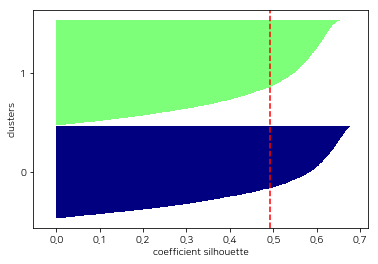

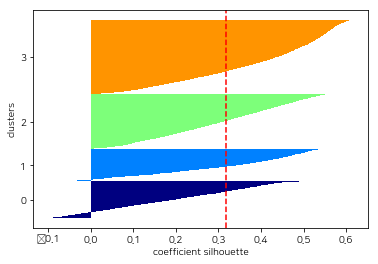

In [91]:
for i in range(len(Xs)):
    plt.figure(i)
    plotSilhouette(Xs[i],y_waves[i])

In [122]:
#클러스터별 데이터의 수는 이렇고
for i in range(len(Xs)):
    print('For', Xs[i].axes[1])
    for k in range(model_waves[i].n_clusters):
        print("The number of cluster",k,sum(model_waves[i].labels_==k))

For Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도',
       '평균기온', '평균수온'],
      dtype='object')
The number of cluster 0 4082
The number of cluster 1 4621
For Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속', '평균 현지기압', '평균습도'], dtype='object')
The number of cluster 0 4654
The number of cluster 1 4049
For Index(['유의파고 평균', '최대파고 최고', '파주기 평균', '파주기 최고', '평균풍속'], dtype='object')
The number of cluster 0 3235
The number of cluster 1 1413
The number of cluster 2 1593
The number of cluster 3 2462


In [123]:
#클러스터의 중심값은 이렇다
for i in range(len(Xs)):
    print(model_waves[i].cluster_centers_,end='\n\n')

[[8.44351875e-01 2.11516785e+00 5.21408968e+00 7.06295026e+00
  5.01791228e+00 1.01333580e+03 8.48544474e+01 1.68267091e+01
  1.67426611e+01]
 [1.31464734e+00 3.16038511e+00 5.97191692e+00 7.87594115e+00
  6.80246646e+00 1.02204494e+03 6.03632627e+01 8.67509736e+00
  1.38043704e+01]]

[[1.30403780e+00 3.13290378e+00 5.96645189e+00 7.87021048e+00
  6.78107818e+00 1.02181375e+03 6.02506443e+01]
 [8.52606869e-01 2.13800346e+00 5.21401038e+00 7.06271312e+00
  5.02752656e+00 1.01352861e+03 8.51897702e+01]]

[[ 0.50108158  1.31344252  4.54548826  6.47623609  3.60466625]
 [ 2.36966054  5.53811881  7.29391796  9.00084866 10.03154173]
 [ 1.11801632  2.67721281  7.18487131  9.46070308  4.81155053]
 [ 1.12556911  2.80215447  5.04577236  6.69565041  7.48170732]]



In [124]:
pd.DataFrame(columns=list(Xs[0].axes[1]), data=model_waves[0].cluster_centers_)

,유의파고 평균,최대파고 최고,파주기 평균,파주기 최고,평균풍속,평균 현지기압,평균습도,평균기온,평균수온
0,0.844352,2.115168,5.214090,7.062950,5.017912,1013.335800,84.854447,16.826709,16.742661
1,1.314647,3.160385,5.971917,7.875941,6.802466,1022.044937,60.363263,8.675097,13.804370


In [125]:
pd.DataFrame(columns=list(Xs[1].axes[1]), data=model_waves[1].cluster_centers_)

,유의파고 평균,최대파고 최고,파주기 평균,파주기 최고,평균풍속,평균 현지기압,평균습도
0,1.304038,3.132904,5.966452,7.870210,6.781078,1021.813746,60.250644
1,0.852607,2.138003,5.214010,7.062713,5.027527,1013.528614,85.189770


In [126]:
pd.DataFrame(columns=list(Xs[2].axes[1]), data=model_waves[2].cluster_centers_)

,유의파고 평균,최대파고 최고,파주기 평균,파주기 최고,평균풍속
0,0.501082,1.313443,4.545488,6.476236,3.604666
1,2.369661,5.538119,7.293918,9.000849,10.031542
2,1.118016,2.677213,7.184871,9.460703,4.811551
3,1.125569,2.802154,5.045772,6.695650,7.481707


### 결과 해석
변수선택을 거친 세가지 모델의 해석은 다음과 같다

1. 큰파도, 작은파도의 클러스터가 형성되는 경향을 보인다
    - 큰파도의 경우 유의파고, 최대파고가 높고, 파주기가 길며, 풍속이 빠르다, 부가적으로 고기압이며 습도가 낮다.
    - 반면 작은파도의 경우 모든 변수가 상반된 모습을 보였다. 일정한 경향을 보이긴 한다
    
    
2. 클러스터의 수는 2개가 가장 적절
    - wss와 실루엣 스코어 모두 k=2를 추천했다
    - 변수를 가장적게 사용한 세번째 모델에서 k=4의 가능성을 보았지만 불안정한 결과이다
    - *그러나 클러스터 수를 늘리는 방향의 모델링이 바람직할 것이다*
    - *클러스터 수가 늘어나면 좀더 활용가능한 결과를 제공할 수 있기 때문(ex 초,중,고급자에 따라 서핑적절여부제공)*
    
    
3. 평균기온, 수온 데이터는 클러스터 형성에 영향 거의 없다
    - 첫번째 모델과 두번째 모델의 cluster centroids의 값이 거의 유사하다
    - 기온과 수온이 파도 자체에는 영향주지 않으므로 상식적이고 바람직한 결과이다
    - 기온과 수온 정보는 사용자의 호불호에 따라 선택적으로 적용가능하다(ex 수온을 중요시 여기는 사용자에겐 수온변수로 필터링한 결과제공)


4. 데이터의 한계가 뚜렷
    - 윈드파인더등의 데이터와 달리 1) 일별 평균데이터라 시간별 정보가 없고, 2)파도와 바람의 방향과 같은 중요한 변수가 없다
    - 클러스터가 2개밖에 안나오는데도 밀집도(실루엣 스코어)가 높지않다
    - 결과적으로 이용자에게 추천할만한 정보가 못됨, 파도가 크다, 안크다의 수준밖에 안된다